## 📑 Navigation

**Part 1: Setup** → Import Libraries, Load Data

**Part 2: Distribution Analysis** → Class Balance, Multi-Label Co-occurrence, Coverage

**Part 3: Linguistic Analysis** → Features, Signatures, Statistical Tests

**Part 4: Vocabulary Analysis** → TF-IDF, Overlap, Discriminative Terms

**Part 5: Summary** → Key Findings, Recommendations, Export

---

# Part 1: Setup & Data Loading
## 1.1 Import Libraries

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1.2 Load Dataset

In [2]:
# Load the dataset
DATA_PATH = "arb.csv"
df = pd.read_csv(DATA_PATH)

print("=" * 70)
print("DATASET OVERVIEW")
print("=" * 70)
print(f"\nTotal samples: {len(df):,}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nFirst few rows:")
display(df.head())

DATASET OVERVIEW

Total samples: 3,380

Columns: ['id', 'text', 'stereotype', 'vilification', 'dehumanization', 'extreme_language', 'lack_of_empathy', 'invalidation']

Data types:
id                  object
text                object
stereotype           int64
vilification         int64
dehumanization       int64
extreme_language     int64
lack_of_empathy      int64
invalidation         int64
dtype: object

Missing values:
id                  0
text                0
stereotype          0
vilification        0
dehumanization      0
extreme_language    0
lack_of_empathy     0
invalidation        0
dtype: int64

First few rows:


,id,text,stereotype,vilification,dehumanization,extreme_language,lack_of_empathy,invalidation
0,arb_a2a60c8b4af3389e842d8ec31afb0eea,احلام انتي ونعالي ومنو انتي حتى تقيمين الفناني...,1,1,1,1,1,0
1,arb_6723e56a672674a6c1d9b28b213c4a05,وره الكواليس تنيجج من وره بعير صطناعي على فكرة...,0,1,1,1,0,1
2,arb_b0365d606edeee38ae6c025b1ca33e96,.خخخخ الملكه احلام فيها شذوذ شنو هل بوس والدلع...,0,1,0,0,1,0
3,arb_858c0ee684049ba6f416a6cecb0b0761,الله يخزي احلام هي والبرنامج الخايس الي كله مصخره,0,1,0,0,0,1
4,arb_bdafc73afd0bc2cd2badae2a089446b9,كس ام احلام الي ماربتها وش ملكه هههه متستاهل م...,1,1,1,1,0,1


---
# Part 2: Class Distribution Analysis
## 2.1 Target Label Distribution

Quantifying class imbalance across all six polarization manifestation categories.

In [3]:
# Define all six polarization manifestation types
MANIFESTATION_TYPES = ['stereotype', 'vilification', 'dehumanization', 'extreme_language', 'lack_of_empathy', 'invalidation']

# Calculate class distributions
print("=" * 70)
print("CLASS DISTRIBUTION ANALYSIS")
print("=" * 70)

distribution_stats = {}
for col in MANIFESTATION_TYPES:
    positive_count = df[col].sum()
    negative_count = len(df) - positive_count
    positive_pct = (positive_count / len(df)) * 100
    
    distribution_stats[col] = {
        'positive': positive_count,
        'negative': negative_count,
        'positive_pct': positive_pct,
        'imbalance_ratio': negative_count / positive_count if positive_count > 0 else np.inf
    }
    
    print(f"\n{'─' * 70}")
    print(f"📊 {col.upper().replace('_', ' ')}")
    print(f"{'─' * 70}")
    print(f"  Positive samples: {positive_count:,} ({positive_pct:.2f}%)")
    print(f"  Negative samples: {negative_count:,} ({100-positive_pct:.2f}%)")
    print(f"  Imbalance ratio: 1:{distribution_stats[col]['imbalance_ratio']:.2f}")

# Create summary DataFrame
summary_df = pd.DataFrame(distribution_stats).T
print("\n" + "=" * 70)
print("SUMMARY TABLE")
print("=" * 70)
display(summary_df)

CLASS DISTRIBUTION ANALYSIS

──────────────────────────────────────────────────────────────────────
📊 STEREOTYPE
──────────────────────────────────────────────────────────────────────
  Positive samples: 1,127 (33.34%)
  Negative samples: 2,253 (66.66%)
  Imbalance ratio: 1:2.00

──────────────────────────────────────────────────────────────────────
📊 VILIFICATION
──────────────────────────────────────────────────────────────────────
  Positive samples: 1,256 (37.16%)
  Negative samples: 2,124 (62.84%)
  Imbalance ratio: 1:1.69

──────────────────────────────────────────────────────────────────────
📊 DEHUMANIZATION
──────────────────────────────────────────────────────────────────────
  Positive samples: 370 (10.95%)
  Negative samples: 3,010 (89.05%)
  Imbalance ratio: 1:8.14

──────────────────────────────────────────────────────────────────────
📊 EXTREME LANGUAGE
──────────────────────────────────────────────────────────────────────
  Positive samples: 1,027 (30.38%)
  Negative samp

,positive,negative,positive_pct,imbalance_ratio
stereotype,1127.0,2253.0,33.343195,1.999113
vilification,1256.0,2124.0,37.159763,1.691083
dehumanization,370.0,3010.0,10.946746,8.135135
extreme_language,1027.0,2353.0,30.384615,2.291139
lack_of_empathy,575.0,2805.0,17.011834,4.878261
invalidation,274.0,3106.0,8.106509,11.335766


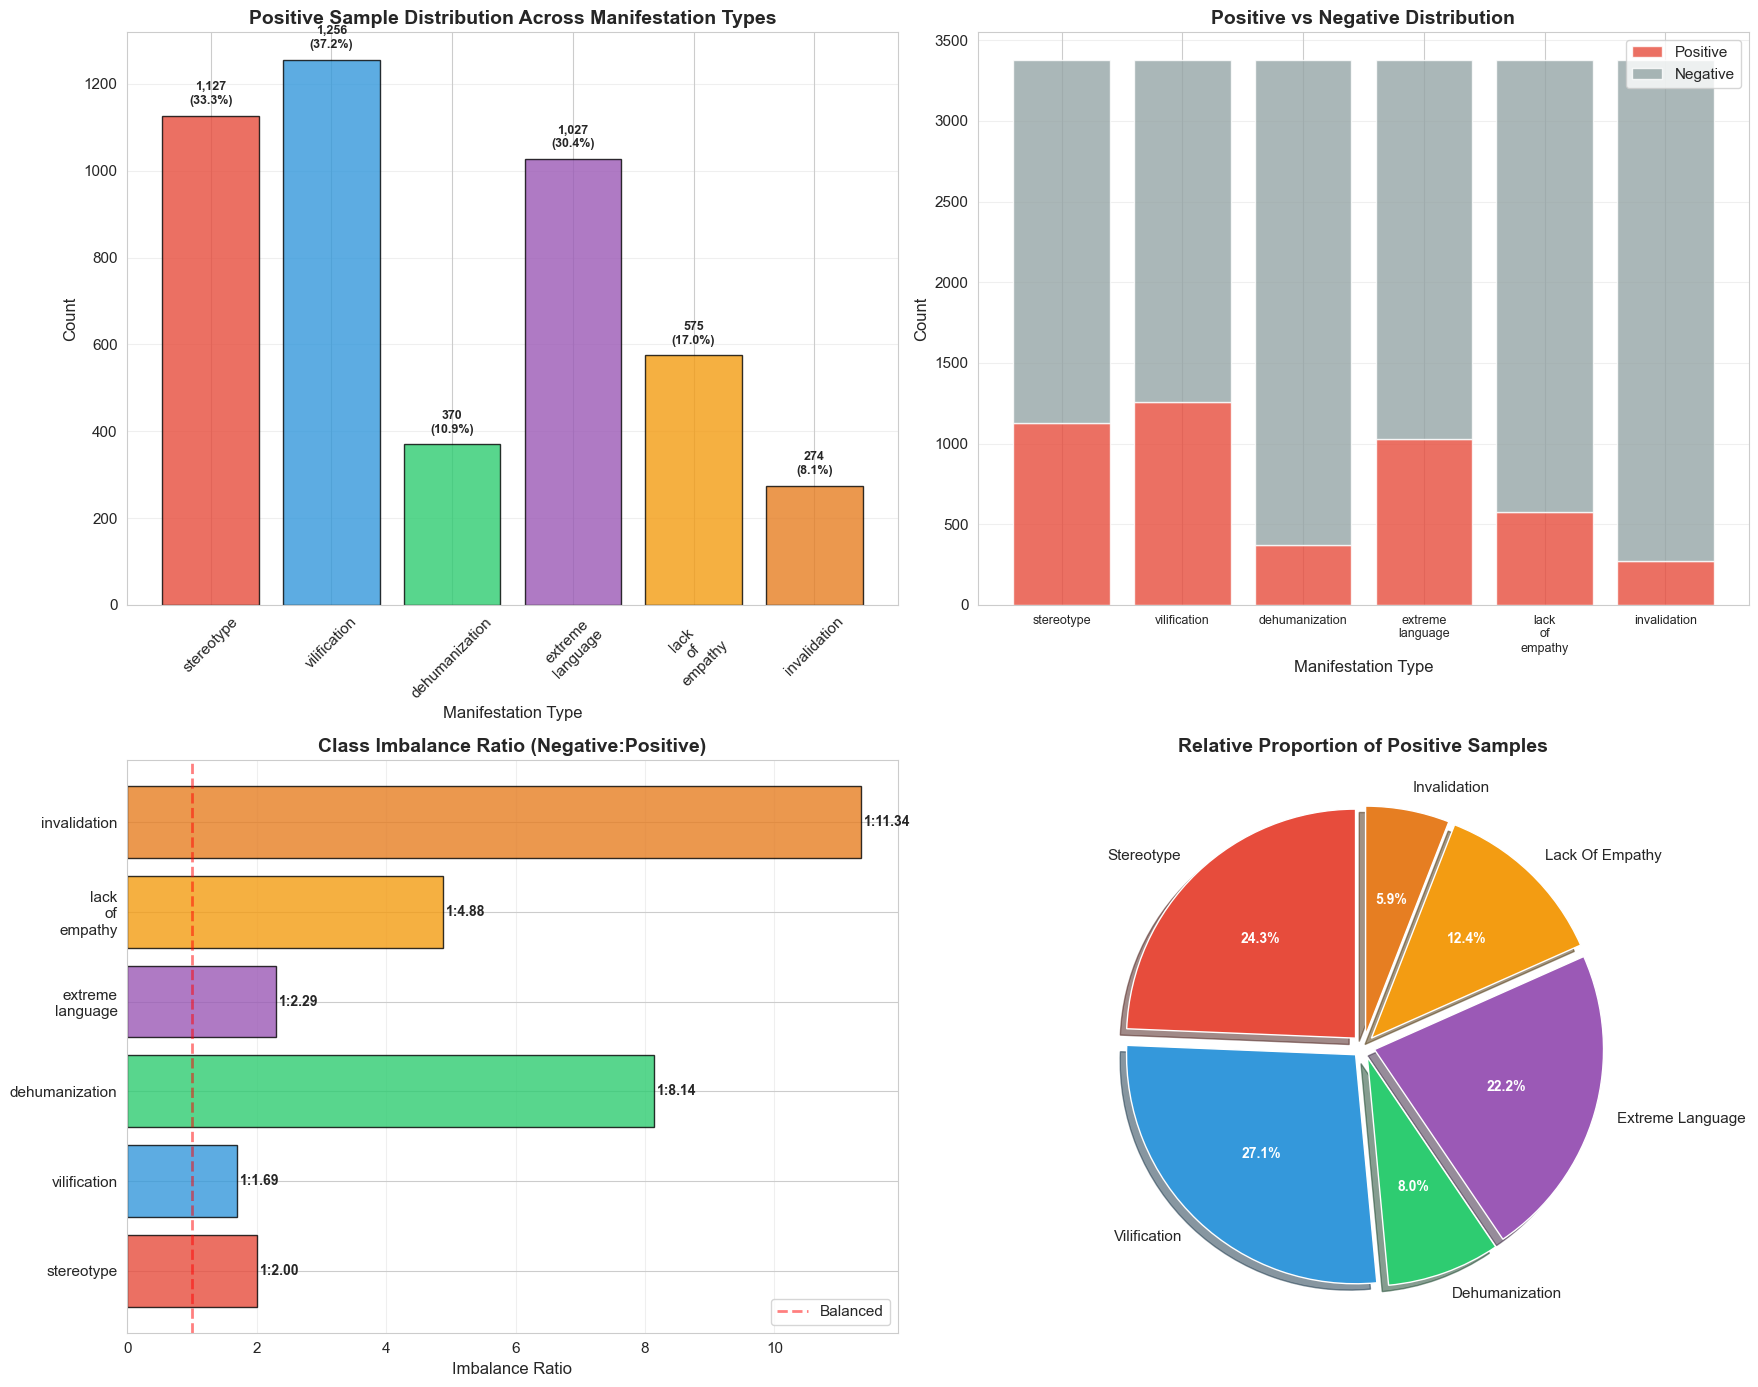


RECOMMENDED CLASS WEIGHTS FOR WEIGHTED LOSS

STEREOTYPE:
  Positive class weight: 1.4996
  Negative class weight: 0.7501

VILIFICATION:
  Positive class weight: 1.3455
  Negative class weight: 0.7957

DEHUMANIZATION:
  Positive class weight: 4.5676
  Negative class weight: 0.5615

EXTREME LANGUAGE:
  Positive class weight: 1.6456
  Negative class weight: 0.7182

LACK OF EMPATHY:
  Positive class weight: 2.9391
  Negative class weight: 0.6025

INVALIDATION:
  Positive class weight: 6.1679
  Negative class weight: 0.5441


In [4]:
# Visualization: Class distribution comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Bar chart comparing positive samples
ax1 = axes[0, 0]
positive_counts = [distribution_stats[col]['positive'] for col in MANIFESTATION_TYPES]
colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12', '#e67e22']
bars = ax1.bar([m.replace('_', '\n') for m in MANIFESTATION_TYPES], positive_counts, color=colors, alpha=0.8, edgecolor='black')
ax1.set_title('Positive Sample Distribution Across Manifestation Types', fontsize=14, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xlabel('Manifestation Type', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
for i, (bar, count) in enumerate(zip(bars, positive_counts)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 20,
            f'{count:,}\n({distribution_stats[MANIFESTATION_TYPES[i]]["positive_pct"]:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=9)
ax1.grid(axis='y', alpha=0.3)

# 2. Stacked bar showing positive/negative split
ax2 = axes[0, 1]
positive_data = [distribution_stats[col]['positive'] for col in MANIFESTATION_TYPES]
negative_data = [distribution_stats[col]['negative'] for col in MANIFESTATION_TYPES]
x_pos = np.arange(len(MANIFESTATION_TYPES))
ax2.bar(x_pos, positive_data, label='Positive', color='#e74c3c', alpha=0.8)
ax2.bar(x_pos, negative_data, bottom=positive_data, label='Negative', color='#95a5a6', alpha=0.8)
ax2.set_xticks(x_pos)
ax2.set_xticklabels([m.replace('_', '\n') for m in MANIFESTATION_TYPES], fontsize=9)
ax2.set_title('Positive vs Negative Distribution', fontsize=14, fontweight='bold')
ax2.set_ylabel('Count', fontsize=12)
ax2.set_xlabel('Manifestation Type', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(axis='y', alpha=0.3)

# 3. Imbalance ratio comparison
ax3 = axes[1, 0]
imbalance_ratios = [distribution_stats[col]['imbalance_ratio'] for col in MANIFESTATION_TYPES]
bars = ax3.barh([m.replace('_', '\n') for m in MANIFESTATION_TYPES], imbalance_ratios, color=colors, alpha=0.8, edgecolor='black')
ax3.set_title('Class Imbalance Ratio (Negative:Positive)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Imbalance Ratio', fontsize=12)
ax3.axvline(x=1, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Balanced')
for i, (bar, ratio) in enumerate(zip(bars, imbalance_ratios)):
    width = bar.get_width()
    ax3.text(width + 0.05, bar.get_y() + bar.get_height()/2.,
            f'1:{ratio:.2f}', ha='left', va='center', fontweight='bold', fontsize=10)
ax3.legend()
ax3.grid(axis='x', alpha=0.3)

# 4. Percentage distribution pie chart
ax4 = axes[1, 1]
positive_percentages = [distribution_stats[col]['positive_pct'] for col in MANIFESTATION_TYPES]
labels = [m.replace('_', ' ').title() for m in MANIFESTATION_TYPES]
wedges, texts, autotexts = ax4.pie(positive_percentages, labels=labels, 
                                     autopct='%1.1f%%', colors=colors, startangle=90,
                                     explode=[0.05]*6, shadow=True)
ax4.set_title('Relative Proportion of Positive Samples', fontsize=14, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

plt.tight_layout()
plt.show()

# Calculate and display recommended class weights for weighted loss
print("\n" + "=" * 70)
print("RECOMMENDED CLASS WEIGHTS FOR WEIGHTED LOSS")
print("=" * 70)
for col in MANIFESTATION_TYPES:
    pos_weight = len(df) / (2 * distribution_stats[col]['positive'])
    neg_weight = len(df) / (2 * distribution_stats[col]['negative'])
    print(f"\n{col.upper().replace('_', ' ')}:")
    print(f"  Positive class weight: {pos_weight:.4f}")
    print(f"  Negative class weight: {neg_weight:.4f}")

## 2.2 Multi-Label Co-occurrence

MULTI-LABEL CO-OCCURRENCE ANALYSIS

Label Count Distribution:
label_count
0    1868
1     195
2     336
3     438
4     313
5     184
6      46
Name: count, dtype: int64

──────────────────────────────────────────────────────────────────────
PAIRWISE CO-OCCURRENCE (Top 10 pairs)
──────────────────────────────────────────────────────────────────────
Stereotype           ∩ Vilification        :   930 samples
Vilification         ∩ Extreme Language    :   870 samples
Stereotype           ∩ Extreme Language    :   830 samples
Vilification         ∩ Lack Of Empathy     :   481 samples
Stereotype           ∩ Lack Of Empathy     :   463 samples
Extreme Language     ∩ Lack Of Empathy     :   453 samples
Vilification         ∩ Dehumanization      :   355 samples
Dehumanization       ∩ Extreme Language    :   296 samples
Stereotype           ∩ Dehumanization      :   271 samples
Vilification         ∩ Invalidation        :   248 samples

All six labels: 46 samples


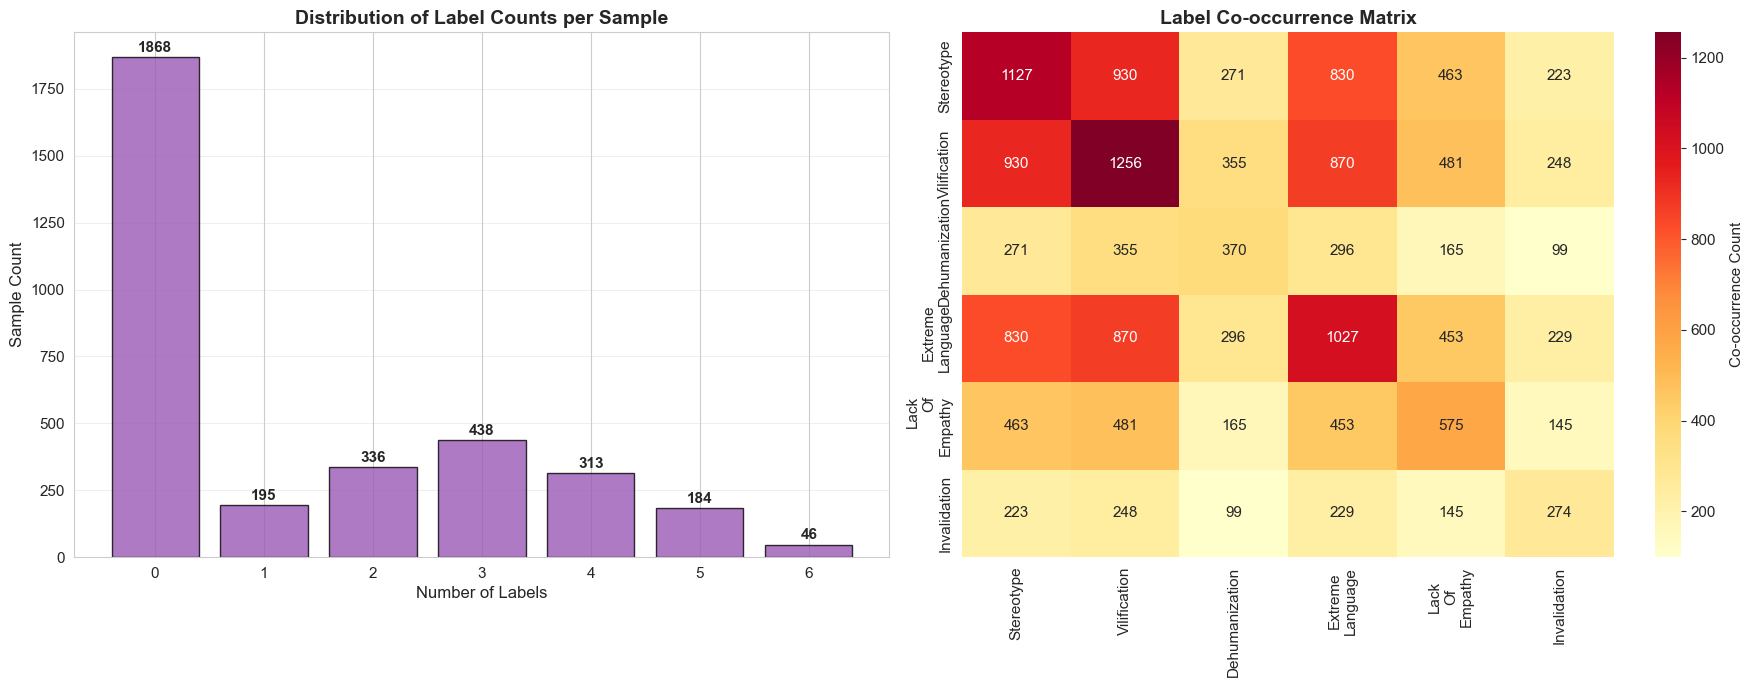

In [5]:
# Multi-label co-occurrence analysis
print("=" * 70)
print("MULTI-LABEL CO-OCCURRENCE ANALYSIS")
print("=" * 70)

# Count samples with multiple labels
df['label_count'] = df[MANIFESTATION_TYPES].sum(axis=1)

print("\nLabel Count Distribution:")
print(df['label_count'].value_counts().sort_index())

# Pairwise co-occurrence
print("\n" + "─" * 70)
print("PAIRWISE CO-OCCURRENCE (Top 10 pairs)")
print("─" * 70)

from itertools import combinations
co_occur_list = []
for col1, col2 in combinations(MANIFESTATION_TYPES, 2):
    co_occur = ((df[col1] == 1) & (df[col2] == 1)).sum()
    co_occur_list.append((col1, col2, co_occur))

co_occur_list.sort(key=lambda x: x[2], reverse=True)
for col1, col2, count in co_occur_list[:10]:
    print(f"{col1.replace('_', ' ').title():20} ∩ {col2.replace('_', ' ').title():20}: {count:5,} samples")

# Samples with all six labels
all_six = df[MANIFESTATION_TYPES].apply(lambda row: all(row == 1), axis=1).sum()
print(f"\nAll six labels: {all_six} samples")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Label count distribution
ax1 = axes[0]
label_dist = df['label_count'].value_counts().sort_index()
ax1.bar(label_dist.index, label_dist.values, color='#9b59b6', alpha=0.8, edgecolor='black')
ax1.set_title('Distribution of Label Counts per Sample', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Labels', fontsize=12)
ax1.set_ylabel('Sample Count', fontsize=12)
for i, v in enumerate(label_dist.values):
    ax1.text(label_dist.index[i], v + 20, str(v), ha='center', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Co-occurrence heatmap
ax2 = axes[1]
co_occurrence_matrix = np.zeros((len(MANIFESTATION_TYPES), len(MANIFESTATION_TYPES)))
for i, col1 in enumerate(MANIFESTATION_TYPES):
    for j, col2 in enumerate(MANIFESTATION_TYPES):
        if i == j:
            co_occurrence_matrix[i, j] = distribution_stats[col1]['positive']
        else:
            co_occurrence_matrix[i, j] = ((df[col1] == 1) & (df[col2] == 1)).sum()

labels = [c.replace('_', '\n').title() for c in MANIFESTATION_TYPES]
sns.heatmap(co_occurrence_matrix, annot=True, fmt='.0f', cmap='YlOrRd', 
            xticklabels=labels,
            yticklabels=labels,
            cbar_kws={'label': 'Co-occurrence Count'}, ax=ax2)
ax2.set_title('Label Co-occurrence Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

---
# Part 3: Linguistic Analysis
## 3.1 Feature Extraction

In [6]:
# Feature extraction functions
def extract_linguistic_features(text):
    """Extract linguistic features from Arabic text."""
    if pd.isna(text):
        return {
            'char_length': 0,
            'word_count': 0,
            'latin_chars': 0,
            'latin_char_ratio': 0,
            'digits': 0,
            'digit_ratio': 0,
            'has_multilingual': 0
        }
    
    text_str = str(text)
    char_length = len(text_str)
    word_count = len(text_str.split())
    
    # Count Latin characters (A-Z, a-z)
    latin_chars = len(re.findall(r'[A-Za-z]', text_str))
    latin_char_ratio = latin_chars / char_length if char_length > 0 else 0
    
    # Count Western digits
    digits = len(re.findall(r'[0-9]', text_str))
    digit_ratio = digits / char_length if char_length > 0 else 0
    
    # Has multilingual elements (code-switching indicator)
    has_multilingual = 1 if (latin_chars > 0 or digits > 0) else 0
    
    return {
        'char_length': char_length,
        'word_count': word_count,
        'latin_chars': latin_chars,
        'latin_char_ratio': latin_char_ratio,
        'digits': digits,
        'digit_ratio': digit_ratio,
        'has_multilingual': has_multilingual
    }

# Extract features for all texts
print("Extracting linguistic features...")
features = df['text'].apply(extract_linguistic_features)
feature_df = pd.DataFrame(features.tolist())

# Merge with original dataframe
df_analysis = pd.concat([df, feature_df], axis=1)

print("✓ Feature extraction complete")
print(f"\nFeatures extracted: {list(feature_df.columns)}")

Extracting linguistic features...
✓ Feature extraction complete

Features extracted: ['char_length', 'word_count', 'latin_chars', 'latin_char_ratio', 'digits', 'digit_ratio', 'has_multilingual']


## 3.2 Linguistic Signatures by Type

In [7]:
# Statistical comparison across manifestation types
print("=" * 70)
print("LINGUISTIC SIGNATURES BY MANIFESTATION TYPE")
print("=" * 70)

linguistic_features = ['char_length', 'word_count', 'latin_char_ratio', 'digit_ratio', 'has_multilingual']

comparison_stats = {}
for manif_type in MANIFESTATION_TYPES:
    print(f"\n{'═' * 70}")
    print(f"📝 {manif_type.upper().replace('_', ' ')}")
    print(f"{'═' * 70}")
    
    positive_samples = df_analysis[df_analysis[manif_type] == 1]
    negative_samples = df_analysis[df_analysis[manif_type] == 0]
    
    comparison_stats[manif_type] = {'positive': {}, 'negative': {}}
    
    for feature in linguistic_features:
        pos_mean = positive_samples[feature].mean()
        neg_mean = negative_samples[feature].mean()
        pos_std = positive_samples[feature].std()
        neg_std = negative_samples[feature].std()
        
        comparison_stats[manif_type]['positive'][feature] = {'mean': pos_mean, 'std': pos_std}
        comparison_stats[manif_type]['negative'][feature] = {'mean': neg_mean, 'std': neg_std}
        
        print(f"\n  {feature.replace('_', ' ').title()}:")
        print(f"    Positive: μ={pos_mean:.2f}, σ={pos_std:.2f}")
        print(f"    Negative: μ={neg_mean:.2f}, σ={neg_std:.2f}")
        diff_pct = ((pos_mean - neg_mean) / neg_mean * 100) if neg_mean != 0 else 0
        print(f"    Difference: {pos_mean - neg_mean:+.2f} ({diff_pct:+.1f}%)")

LINGUISTIC SIGNATURES BY MANIFESTATION TYPE

══════════════════════════════════════════════════════════════════════
📝 STEREOTYPE
══════════════════════════════════════════════════════════════════════

  Char Length:
    Positive: μ=102.05, σ=39.69
    Negative: μ=91.53, σ=46.70
    Difference: +10.52 (+11.5%)

  Word Count:
    Positive: μ=18.03, σ=7.04
    Negative: μ=16.05, σ=8.39
    Difference: +1.98 (+12.3%)

  Latin Char Ratio:
    Positive: μ=0.00, σ=0.01
    Negative: μ=0.00, σ=0.01
    Difference: -0.00 (-18.2%)

  Digit Ratio:
    Positive: μ=0.00, σ=0.01
    Negative: μ=0.01, σ=0.02
    Difference: -0.00 (-85.9%)

  Has Multilingual:
    Positive: μ=0.05, σ=0.21
    Negative: μ=0.14, σ=0.34
    Difference: -0.09 (-66.5%)

══════════════════════════════════════════════════════════════════════
📝 VILIFICATION
══════════════════════════════════════════════════════════════════════

  Char Length:
    Positive: μ=98.10, σ=38.53
    Negative: μ=93.23, σ=47.97
    Difference: +4.88 

## 3.3 Visualizations

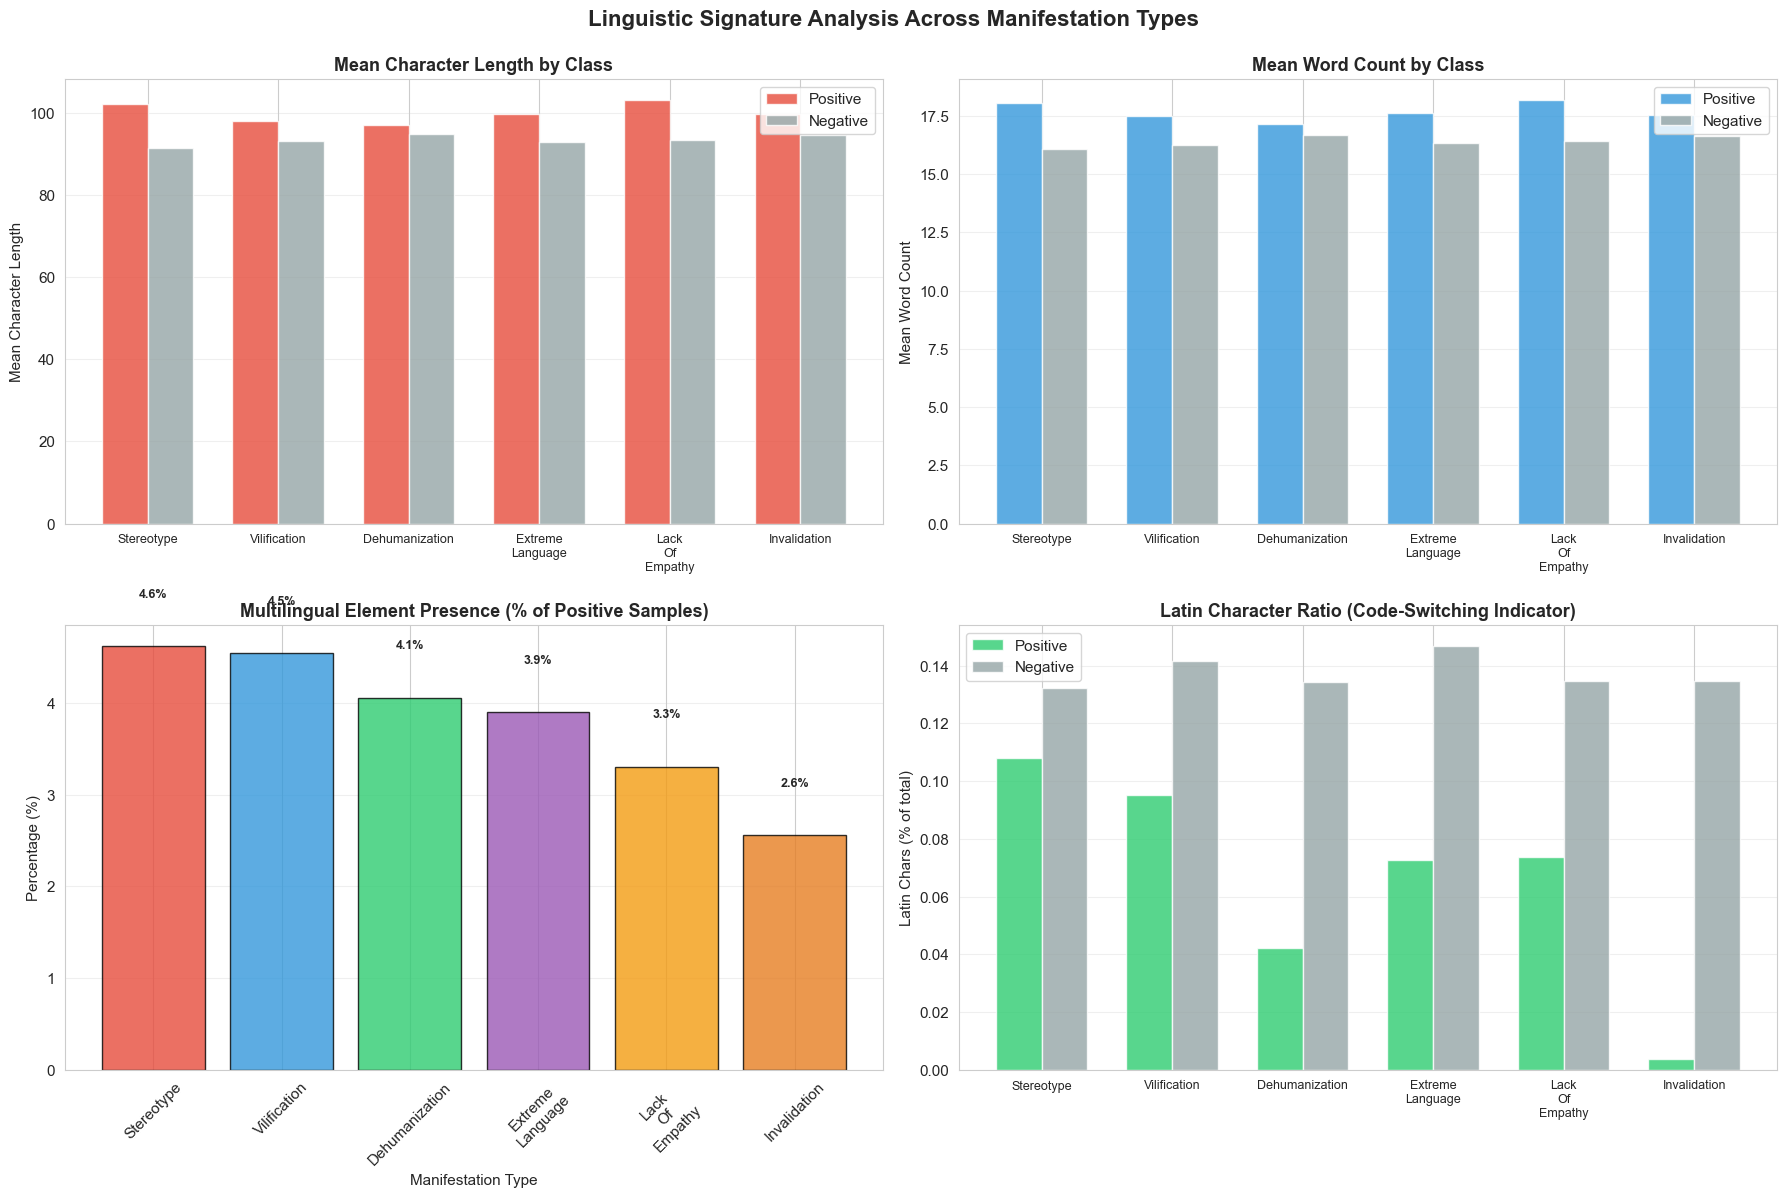

In [8]:
# Comprehensive visualization of linguistic signatures
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Linguistic Signature Analysis Across Manifestation Types', fontsize=16, fontweight='bold', y=0.995)

colors_manif = {m: c for m, c in zip(MANIFESTATION_TYPES, colors)}

# 1. Mean Character Length Comparison
ax1 = axes[0, 0]
pos_means = [comparison_stats[mt]['positive']['char_length']['mean'] for mt in MANIFESTATION_TYPES]
neg_means = [comparison_stats[mt]['negative']['char_length']['mean'] for mt in MANIFESTATION_TYPES]
x = np.arange(len(MANIFESTATION_TYPES))
width = 0.35
ax1.bar(x - width/2, pos_means, width, label='Positive', color='#e74c3c', alpha=0.8)
ax1.bar(x + width/2, neg_means, width, label='Negative', color='#95a5a6', alpha=0.8)
ax1.set_title('Mean Character Length by Class', fontsize=13, fontweight='bold')
ax1.set_ylabel('Mean Character Length', fontsize=11)
ax1.set_xticks(x)
ax1.set_xticklabels([mt.replace('_', '\n').title() for mt in MANIFESTATION_TYPES], fontsize=9)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Mean Word Count Comparison
ax2 = axes[0, 1]
pos_means = [comparison_stats[mt]['positive']['word_count']['mean'] for mt in MANIFESTATION_TYPES]
neg_means = [comparison_stats[mt]['negative']['word_count']['mean'] for mt in MANIFESTATION_TYPES]
ax2.bar(x - width/2, pos_means, width, label='Positive', color='#3498db', alpha=0.8)
ax2.bar(x + width/2, neg_means, width, label='Negative', color='#95a5a6', alpha=0.8)
ax2.set_title('Mean Word Count by Class', fontsize=13, fontweight='bold')
ax2.set_ylabel('Mean Word Count', fontsize=11)
ax2.set_xticks(x)
ax2.set_xticklabels([mt.replace('_', '\n').title() for mt in MANIFESTATION_TYPES], fontsize=9)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Multilingual Element Presence
ax3 = axes[1, 0]
multilingual_pct = []
for manif_type in MANIFESTATION_TYPES:
    positive_samples = df_analysis[df_analysis[manif_type] == 1]
    pct = (positive_samples['has_multilingual'].sum() / len(positive_samples)) * 100 if len(positive_samples) > 0 else 0
    multilingual_pct.append(pct)
bars = ax3.bar([mt.replace('_', '\n').title() for mt in MANIFESTATION_TYPES], multilingual_pct, 
               color=[colors_manif[mt] for mt in MANIFESTATION_TYPES], 
               alpha=0.8, edgecolor='black')
ax3.set_title('Multilingual Element Presence (% of Positive Samples)', fontsize=13, fontweight='bold')
ax3.set_ylabel('Percentage (%)', fontsize=11)
ax3.set_xlabel('Manifestation Type', fontsize=11)
ax3.tick_params(axis='x', rotation=45)
for bar, pct in zip(bars, multilingual_pct):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)
ax3.grid(axis='y', alpha=0.3)

# 4. Latin Character Ratio Comparison
ax4 = axes[1, 1]
pos_means = [comparison_stats[mt]['positive']['latin_char_ratio']['mean'] * 100 for mt in MANIFESTATION_TYPES]
neg_means = [comparison_stats[mt]['negative']['latin_char_ratio']['mean'] * 100 for mt in MANIFESTATION_TYPES]
ax4.bar(x - width/2, pos_means, width, label='Positive', color='#2ecc71', alpha=0.8)
ax4.bar(x + width/2, neg_means, width, label='Negative', color='#95a5a6', alpha=0.8)
ax4.set_title('Latin Character Ratio (Code-Switching Indicator)', fontsize=13, fontweight='bold')
ax4.set_ylabel('Latin Chars (% of total)', fontsize=11)
ax4.set_xticks(x)
ax4.set_xticklabels([mt.replace('_', '\n').title() for mt in MANIFESTATION_TYPES], fontsize=9)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---
# Part 4: Vocabulary Analysis  
## 4.1 TF-IDF: Unigrams

In [9]:
# Prepare data for TF-IDF analysis
def get_class_texts(df, class_name):
    """Extract texts for a specific class."""
    return df[df[class_name] == 1]['text'].dropna().astype(str).tolist()

# Extract texts for each manifestation type
class_texts = {}
for manif_type in MANIFESTATION_TYPES:
    class_texts[manif_type] = get_class_texts(df_analysis, manif_type)
    print(f"{manif_type.replace('_', ' ').title()}: {len(class_texts[manif_type])} texts")

print("\n" + "=" * 70)
print("TF-IDF ANALYSIS: TOP DISCRIMINATIVE UNIGRAMS")
print("=" * 70)

# Initialize TF-IDF vectorizer for unigrams
tfidf_unigram = TfidfVectorizer(
    max_features=100,
    ngram_range=(1, 1),
    min_df=2,
    max_df=0.95
)

unigram_results = {}

for manif_type in MANIFESTATION_TYPES:
    print(f"\n{'═' * 70}")
    print(f"🔍 {manif_type.upper().replace('_', ' ')} - TOP 20 UNIGRAMS")
    print(f"{'═' * 70}")
    
    if len(class_texts[manif_type]) > 0:
        # Fit TF-IDF
        tfidf_matrix = tfidf_unigram.fit_transform(class_texts[manif_type])
        feature_names = tfidf_unigram.get_feature_names_out()
        
        # Calculate mean TF-IDF scores
        mean_tfidf = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
        
        # Get top words
        top_indices = mean_tfidf.argsort()[-20:][::-1]
        top_words = [(feature_names[i], mean_tfidf[i]) for i in top_indices]
        
        unigram_results[manif_type] = top_words
        
        # Display results
        for rank, (word, score) in enumerate(top_words, 1):
            print(f"{rank:2d}. {word:30s} (TF-IDF: {score:.4f}")
    else:
        print("  No samples found for this manifestation type")
        unigram_results[manif_type] = []

print("\n" + "=" * 70)

Stereotype: 1127 texts
Vilification: 1256 texts
Dehumanization: 370 texts
Extreme Language: 1027 texts
Lack Of Empathy: 575 texts
Invalidation: 274 texts

TF-IDF ANALYSIS: TOP DISCRIMINATIVE UNIGRAMS

══════════════════════════════════════════════════════════════════════
🔍 STEREOTYPE - TOP 20 UNIGRAMS
══════════════════════════════════════════════════════════════════════
 1. من                             (TF-IDF: 0.0982
 2. في                             (TF-IDF: 0.0799
 3. على                            (TF-IDF: 0.0665
 4. الله                           (TF-IDF: 0.0442
 5. ما                             (TF-IDF: 0.0406
 6. لا                             (TF-IDF: 0.0369
 7. يا                             (TF-IDF: 0.0363
 8. مع                             (TF-IDF: 0.0344
 9. كل                             (TF-IDF: 0.0301
10. عن                             (TF-IDF: 0.0274
11. هذا                            (TF-IDF: 0.0251
12. ولا                            (TF-IDF: 0.0236
13. هو        

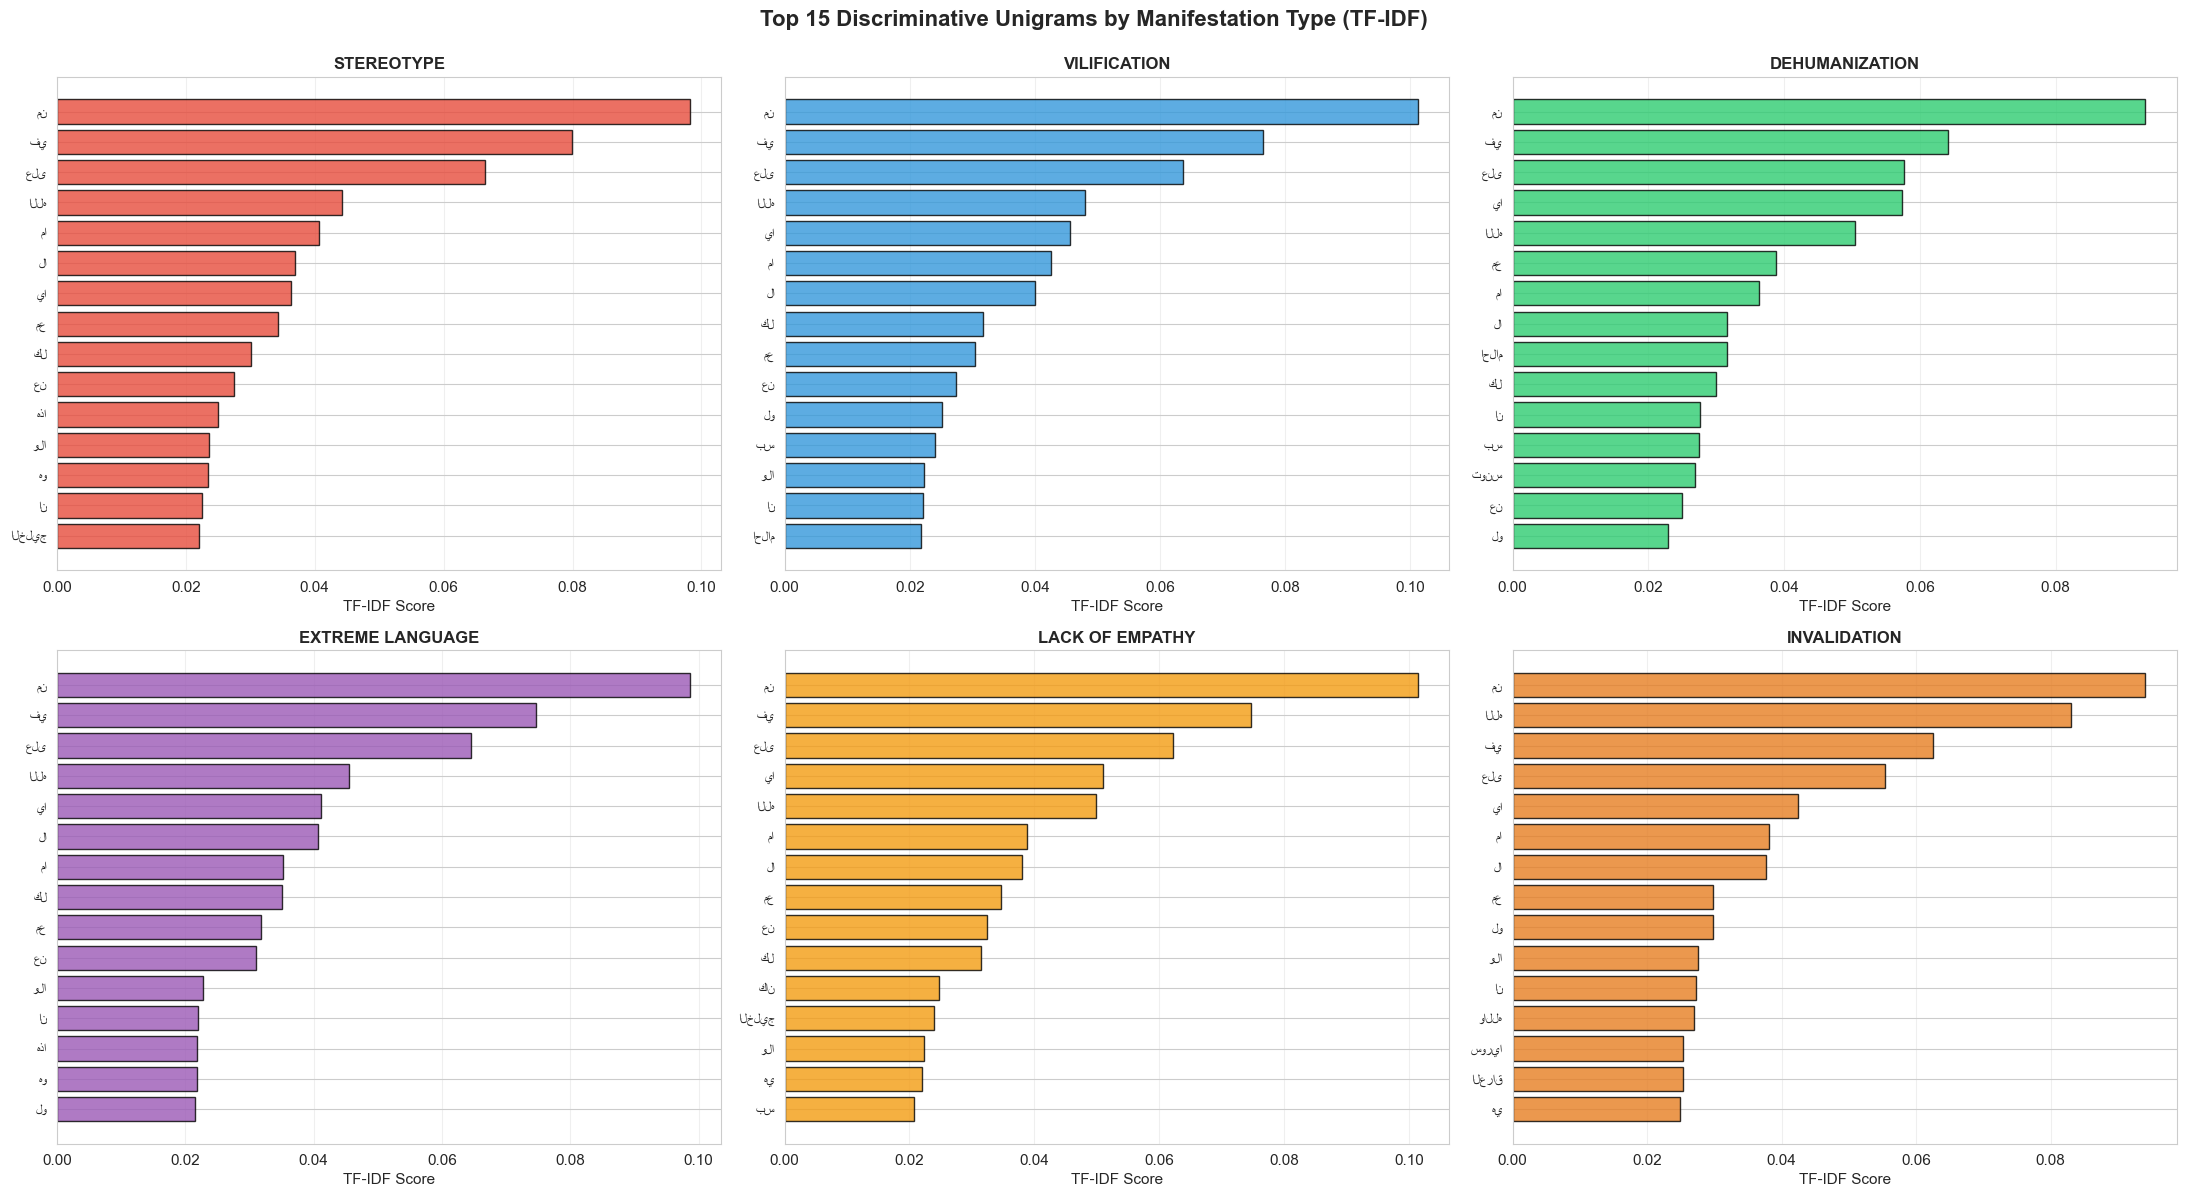

In [10]:
# Visualize top discriminative words
fig, axes = plt.subplots(2, 3, figsize=(22, 12))
fig.suptitle('Top 15 Discriminative Unigrams by Manifestation Type (TF-IDF)', 
             fontsize=16, fontweight='bold', y=0.995)

# Flatten axes for easier iteration
axes_flat = axes.flatten()

for idx, manif_type in enumerate(MANIFESTATION_TYPES):
    ax = axes_flat[idx]
    
    if len(unigram_results[manif_type]) > 0:
        # Get top 15 words
        top_15 = unigram_results[manif_type][:15]
        words = [w[0] for w in top_15]
        scores = [w[1] for w in top_15]
        
        # Create horizontal bar plot
        y_pos = np.arange(len(words))
        ax.barh(y_pos, scores, color=colors_manif[manif_type], alpha=0.8, edgecolor='black')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(words, fontsize=9)
        ax.invert_yaxis()
        ax.set_xlabel('TF-IDF Score', fontsize=11)
        ax.set_title(f'{manif_type.upper().replace("_", " ")}', fontsize=12, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=14)
        ax.set_title(f'{manif_type.upper().replace("_", " ")}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

---
# Part 5: Summary & Recommendations
## 5.1 Key Findings

In [11]:
# Generate comprehensive summary report
print("=" * 70)
print("COMPREHENSIVE EDA SUMMARY REPORT")
print("=" * 70)

summary_report = f"""
Dataset: arb copy.csv
Total Samples: {len(df):,}

CLASS DISTRIBUTION:
{'─' * 70}
"""

for manif_type in MANIFESTATION_TYPES:
    stats = distribution_stats[manif_type]
    summary_report += f"""
{manif_type.upper().replace('_', ' ')}:
  Positive: {stats['positive']:,} ({stats['positive_pct']:.2f}%)
  Negative: {stats['negative']:,} ({100-stats['positive_pct']:.2f}%)
  Imbalance: 1:{stats['imbalance_ratio']:.2f}
"""

summary_report += f"""
LINGUISTIC SIGNATURES (Positive Samples):
{'─' * 70}
"""

for manif_type in MANIFESTATION_TYPES:
    stats = comparison_stats[manif_type]['positive']
    summary_report += f"""
{manif_type.upper().replace('_', ' ')}:
  Avg Character Length: {stats['char_length']['mean']:.1f} ± {stats['char_length']['std']:.1f}
  Avg Word Count: {stats['word_count']['mean']:.1f} ± {stats['word_count']['std']:.1f}
  Latin Char Ratio: {stats['latin_char_ratio']['mean']*100:.2f}%
  Multilingual Presence: {stats['has_multilingual']['mean']*100:.1f}%
"""

summary_report += f"""
TOP 5 DISCRIMINATIVE WORDS:
{'─' * 70}
"""

for manif_type in MANIFESTATION_TYPES:
    if len(unigram_results[manif_type]) >= 5:
        top_5 = [w[0] for w in unigram_results[manif_type][:5]]
        summary_report += f"\n{manif_type.upper().replace('_', ' ')}: {', '.join(top_5)}"
    else:
        summary_report += f"\n{manif_type.upper().replace('_', ' ')}: [Insufficient data]"

summary_report += "\n\n" + "=" * 70

print(summary_report)

# Save report to file
with open('EDA_Polarization_Manifestations_Report.txt', 'w', encoding='utf-8') as f:
    f.write(summary_report)

print("\n✓ Summary report saved to 'EDA_Polarization_Manifestations_Report.txt'")

print("\n" + "=" * 70)
print("📊 EDA COMPLETE - All analyses finished!")
print("=" * 70)

COMPREHENSIVE EDA SUMMARY REPORT

Dataset: arb copy.csv
Total Samples: 3,380

CLASS DISTRIBUTION:
──────────────────────────────────────────────────────────────────────

STEREOTYPE:
  Positive: 1,127 (33.34%)
  Negative: 2,253 (66.66%)
  Imbalance: 1:2.00

VILIFICATION:
  Positive: 1,256 (37.16%)
  Negative: 2,124 (62.84%)
  Imbalance: 1:1.69

DEHUMANIZATION:
  Positive: 370 (10.95%)
  Negative: 3,010 (89.05%)
  Imbalance: 1:8.14

EXTREME LANGUAGE:
  Positive: 1,027 (30.38%)
  Negative: 2,353 (69.62%)
  Imbalance: 1:2.29

LACK OF EMPATHY:
  Positive: 575 (17.01%)
  Negative: 2,805 (82.99%)
  Imbalance: 1:4.88

INVALIDATION:
  Positive: 274 (8.11%)
  Negative: 3,106 (91.89%)
  Imbalance: 1:11.34

LINGUISTIC SIGNATURES (Positive Samples):
──────────────────────────────────────────────────────────────────────

STEREOTYPE:
  Avg Character Length: 102.1 ± 39.7
  Avg Word Count: 18.0 ± 7.0
  Latin Char Ratio: 0.11%
  Multilingual Presence: 4.6%

VILIFICATION:
  Avg Character Length: 98.1 ± 3